In [2]:
%matplotlib inline
import sys
import os
sys.path.append('/home/kihyun/data/projects/kihyun/Editing-benchmark/cocoapi/PythonAPI')
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import json
from tqdm import tqdm
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

In [3]:
dataDir='/home/kihyun/data/dataset/COCO2017'
dataType='val2017'
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)
json_dir = '/home/kihyun/data/projects/kihyun/Editing-benchmark/edit_task_v2.json'
catnms = [] # 해당 object가 모두 있는 이미지만 선택 및 프롬프트 저장
Annotation = True # Annotation mask를 이미지에 표시할지 여부
save_dir = './img_above_certain_size_bbox' # 프롬프트 저장 위치
save_img = False

In [4]:
cat_dir = '_'.join(catnms) # 프롬프트 저장 위치
save_path = os.path.join(save_dir, cat_dir)
if not os.path.exists(save_path):
        os.makedirs(save_path)

In [5]:
# initialize COCO api for instance annotations
# annotation file을 읽어서 COCO object를 생성
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.54s)
creating index...
index created!


In [8]:
def img_idx_list(coco):
    imgIds = coco.getImgIds()
    print("Number of images in the dataset: ", len(imgIds))
    return len(imgIds), imgIds

def img_show(coco, imgId, mask=False, catnms=None, save_path=save_path, save = save_img):
    img = coco.loadImgs(imgId)[0]
    I = io.imread('%s/images/%s/%s'%(dataDir,dataType,img['file_name']))
    #I = io.imread(img['coco_url'])
    plt.axis('off')
    plt.imshow(I)
    if mask:
        annIds = coco.getAnnIds(imgIds=img['id'], iscrowd=None)
        anns = coco.loadAnns(annIds)
        coco.showAnns(anns)
    if save:
        save_name = f'{imgId}.jpg'
        img_path = os.path.join(save_path, save_name)
        plt.savefig(img_path)
    plt.close()
    
def multi_img_show(coco, imgId_ls, mask=False, catnms=None):
    # valid_imgIds = []

    count = 0
    for i, imgId in enumerate(tqdm(imgId_ls, desc="Downloading images")):
        image_summary = calculate_image_summary(coco, [imgId])
        if image_summary:
            img_show(coco, imgId, mask)
            # valid_imgIds.append(imgId)
            count += 1
    
    # with open('./img_above_certain_size_bbox_list.txt', 'w') as f:
    #     for valid_imgId in valid_imgIds:
    #         f.write(f'{valid_imgId}\n')
    
    return count
        
def save_edit_prompts(json_dir, save_path=save_path):
    # read json file
    with open(json_dir, 'r') as f:
        json_data = json.load(f)
    # save edit prompts in prompt_save_dir
   
    file_name = f'edit_prompts_{catnms}.txt'
    txt_path = os.path.join(save_path, file_name)
    ff = open(txt_path, 'w')
    for cat in catnms:
        for edit_task in json_data[cat].keys():
            for subtask in json_data[cat][edit_task]['to']:
                ff.write(f'{cat}, {edit_task}, {subtask}\n')
                ff.write('---------------------\n')
    ff.close()

def calculate_image_summary(coco, imgId_ls):
    category_info = {}  # {category_name: [count, total_area]}

    for imgId in imgId_ls:
        annIds = coco.getAnnIds(imgIds=imgId)
        anns = coco.loadAnns(annIds)
        for ann in anns:
            category_name = coco.loadCats(ann['category_id'])[0]['name']
            bbox = ann['bbox']  # [x, y, width, height]
            width, height = bbox[2], bbox[3]
            area = width * height
            if area < 1000:
                process_single_image(coco, imgId, json_dir)
                return None
            if category_name not in category_info:
                category_info[category_name] = [0]
            category_info[category_name][0] += 1
            if category_info[category_name][0] >= 2:
                process_single_image(coco, imgId, json_dir)
                return None
            category_info[category_name].append(area)
    
    image_summary = {cat: info for cat, info in category_info.items()}
    return image_summary

def calculate_single_image_summary(coco, imgId_ls):
    category_info = {}  # {category_name: [count, total_area]}

    for imgId in imgId_ls:
        annIds = coco.getAnnIds(imgIds=imgId)
        anns = coco.loadAnns(annIds)
        for ann in anns:
            category_name = coco.loadCats(ann['category_id'])[0]['name']
            bbox = ann['bbox']  # [x, y, width, height]
            width, height = bbox[2], bbox[3]
            area = width * height
            if category_name not in category_info:
                category_info[category_name] = [0]
            category_info[category_name][0] += 1
            category_info[category_name].append(area)

    image_summary = {cat: info for cat, info in category_info.items()}
    return image_summary

def show_cat_imgs_n_prompt(coco, json_dir):
    n, imgId_ls = img_idx_list(coco)
    i = multi_img_show(coco, imgId_ls, mask=Annotation)
    # save_edit_prompts(catnms, json_dir)   # 일단 이미지만 체크
    return i

def process_single_image(coco, imgId, json_dir):
    img_show(coco, imgId, mask=Annotation, save_path='./small_bbox_or_multi_cats/', save=False)
    # image_summary = calculate_single_image_summary(coco, imgId)
    # return image_summary

{'bottle': [1, 2251.6725],
 'dining table': [1, 64736.6188],
 'person': [2, 30374.4042, 2285.6232],
 'knife': [1, 642.5928],
 'bowl': [4, 2781.3396000000002, 3141.6909999999993, 445.8939, 282.5452],
 'oven': [2, 18942.127200000003, 18940.812800000003],
 'cup': [2, 850.085, 1154.3334],
 'broccoli': [3, 60.0446, 267.8728, 42.502399999999994],
 'spoon': [1, 163.8756],
 'carrot': [1, 38.1024],
 'sink': [1, 3490.7061]}

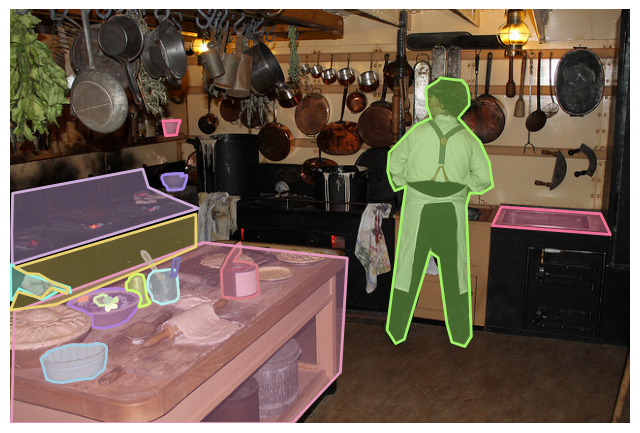

In [10]:
image_summary = process_single_image(coco, [397133], json_dir)
image_summary

In [9]:
i = show_cat_imgs_n_prompt(coco, json_dir)
i

Number of images in the dataset:  5000


1517